In [20]:
import geopandas as gpd
from shapely.geometry import LineString
import pandas as pd
import networkx as nx
import sqlite3
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap


In [21]:
with sqlite3.connect('../../Dataset/submarine_cable.sqlite') as con:
    c = con.cursor()
    cable_coor = pd.read_sql("select  geometry, lp.cable_id, lp.cable_name, cmlcc.merge_length as cable_length, cmlcc.merge_capacity as cable_capacity, cmlcc.merge_cost as cable_cost from landing_points lp left join cable_coor cc on lp.cable_id = cc.id left join cable_merge_length_capacity_cost cmlcc on lp.cable_id = cmlcc.cable_id group by geometry",con=con)
    landingPoint = pd.read_sql("select * from landing_points",con=con)

# cable_shap = gpd.GeoDataFrame(cable_coor, crs=4326)

In [22]:
cable_coor[cable_coor['cable_length'].isna() == True]

,geometry,cable_id,cable_name,cable_length,cable_capacity,cable_cost


In [23]:
cleaned_cable_coor = cable_coor["geometry"].str.replace("MULTILINESTRING \(\(", "").str.replace("\)", "").str.replace("'","")
# coor_list = cleaned_cable_coor.iloc[0].split(', (')
cleaned_cable_coor.iloc[2].split(', (')

index_cable_id = list(cable_coor.columns).index('cable_id')
index_cable_length = list(cable_coor.columns).index('cable_length')
index_cable_capacity = list(cable_coor.columns).index('cable_capacity')
index_cable_cost = list(cable_coor.columns).index('cable_cost')


data = pd.DataFrame()

for row in range(cleaned_cable_coor.shape[0]):
    coor_list = cleaned_cable_coor.iloc[row].split(', (')
    cable_id = cable_coor.iloc[row,index_cable_id]
    cable_length = cable_coor.iloc[row,index_cable_length]
    cable_capacity = cable_coor.iloc[row,index_cable_capacity]
    cable_cost = cable_coor.iloc[row,index_cable_cost]

    for x in coor_list:
        seg = pd.DataFrame()
        abc = x.split(', ')
        # print(abc)
        for y in abc:
            a = {'lon1': y.split(' ')[0], 'lat1': y.split(' ')[1], 'cable_id': cable_id, 'cable_length': cable_length, 'cable_capacity': cable_capacity,'cable_cost': cable_cost}
            seg = seg.append(a,ignore_index=True)
        seg["lon1"] = seg["lon1"].astype("float64")
        seg["lat1"] = seg["lat1"].astype("float64")
        seg['lon2'] = seg['lon1'].shift()
        seg['lat2'] = seg['lat1'].shift()
        data = data.append(seg,ignore_index=True)
data

/var/folders/93/98m4gg790h36hw_xcd31b1d40000gn/T/ipykernel_43800/2595705227.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  cleaned_cable_coor = cable_coor["geometry"].str.replace("MULTILINESTRING \(\(", "").str.replace("\)", "").str.replace("'","")


,lon1,lat1,cable_id,cable_length,cable_capacity,cable_cost,lon2,lat2
0,-0.134426,50.828479,crosschannel-fibre,149.0,2400.000000,3.875,NaN,NaN
1,0.000074,50.597677,crosschannel-fibre,149.0,2400.000000,3.875,-0.134426,50.828479
2,0.450074,50.022920,crosschannel-fibre,149.0,2400.000000,3.875,0.000074,50.597677
3,0.797774,49.877307,crosschannel-fibre,149.0,2400.000000,3.875,0.450074,50.022920
4,-0.204316,5.558286,glo-1,9800.0,2.500000,260.000,NaN,NaN
...,...,...,...,...,...,...,...,...
11075,101.250003,2.425987,damai-cable-system,575.0,44.384991,14.375,100.575003,2.705081
11076,101.758252,2.143087,damai-cable-system,575.0,44.384991,14.375,101.250003,2.425987
11077,101.870752,1.976445,damai-cable-system,575.0,44.384991,14.375,101.758252,2.143087
11078,101.728127,1.805588,damai-cable-system,575.0,44.384991,14.375,101.870752,1.976445


In [24]:
# data['lon2'] = data['lon1'].shift()
# data['lat2'] = data['lat1'].shift()
# data["lon1"] = data["lon1"].astype("float64")
# data["lat1"] = data["lat1"].astype("float64")

In [25]:
# cable_coor.iloc[0,1]
# cable_coor.iloc[2,1]

In [26]:
# data.dropna()
gdf = gpd.GeoDataFrame(data)
    # data,geometry=gpd.points_from_xy(data.lon1, data.lat1), crs=4326)
gdf['fr_point'] = gpd.points_from_xy(x=gdf['lon1'],y=gdf['lat1'])
gdf['to_point'] = gpd.points_from_xy(x=gdf['lon2'],y=gdf['lat2'])
gdf['fr_id'] = round((round(gdf['lon1'],5) + round(gdf['lat1'],5))*100000,0)
gdf['to_id'] = round((round(gdf['lon2'],5) + round(gdf['lat2'],5))*100000,0)
gdf['distance_from_previous'] = gdf['fr_point'].distance(gdf['to_point'])
gdf['total_distance'] = gdf.groupby('cable_id')['distance_from_previous'].transform('sum')
gdf['length_from_previous'] = gdf['cable_length'] / gdf['total_distance'] * gdf['distance_from_previous']
gdf['segment_cost'] = gdf['cable_cost']/gdf['cable_length'] * gdf['length_from_previous']
gdf['inverse_capacity'] = 1/gdf['cable_capacity']

In [27]:
gdf[gdf['cable_length'].isna()==True]

,lon1,lat1,cable_id,cable_length,cable_capacity,cable_cost,lon2,lat2,fr_point,to_point,fr_id,to_id,distance_from_previous,total_distance,length_from_previous,segment_cost,inverse_capacity


In [28]:
gdf = gdf[gdf['to_id'].isna() == False].iloc[1::,]
gdf['line'] = gdf.apply(lambda row: LineString([row['fr_point'], row['to_point']]), axis=1) #Create a linestring column


In [29]:
gdf.to_csv("/Users/dijiongyuequ/Downloads/cable_distance.csv")

<AxesSubplot:>

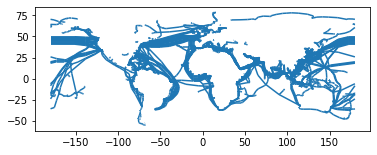

In [30]:
gdf = gpd.GeoDataFrame(gdf, geometry=gdf['line'])
gdf.plot()

In [31]:
gdf = gdf.reset_index( )


In [32]:

gdf.query('lon1 < 121.4726 and lon1 > 121.4725')

,index,lon1,lat1,cable_id,cable_length,cable_capacity,cable_cost,lon2,lat2,fr_point,to_point,fr_id,to_id,distance_from_previous,total_distance,length_from_previous,segment_cost,inverse_capacity,line,geometry
4178,4776,121.472587,31.247574,seamewe-3,39000.0,0.139855,1007.78,122.174988,31.238657,POINT (121.47259 31.24757),POINT (122.17499 31.23866),15272016.0,15341365.0,0.702457,355.922922,76.971256,1.988977,7.150281,LINESTRING (121.47258699999978 31.247573900928...,"LINESTRING (121.47259 31.24757, 122.17499 31.2..."


In [33]:
G = nx.from_pandas_edgelist(gdf, 'fr_id', 'to_id', edge_attr=['index', 'length_from_previous','segment_cost','inverse_capacity'], create_using=nx.Graph)


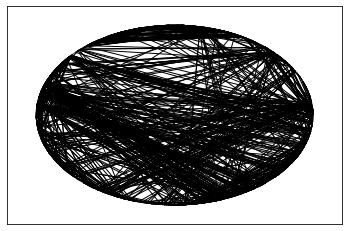

In [34]:
nx.draw_networkx_edges(G, pos=nx.circular_layout(G))


In [35]:
path = nx.shortest_path(G,6181995, 4629267, weight = 'length_from_previous')

# def getPath(path, road):
#     pathroad = pd.DataFrame()
#     for i in range(5):
#         # len(path.keys())-1
#         node1 = path[list (path.keys())[i]]
#         print(node1)
#         node2 = path[list (path.keys())[i+1]]
#         print(node2)
#         r = road[(road['fr_id'] == node1) & (road['to_id'] == node2)]
#         pathroad = pathroad.append(r)
#     return pathroad

def getPath(path, road):
    pathroad = pd.DataFrame()
    for i in range(len(path)-1):
        # len(path.keys())-1
        node1 = path[i]
        node2 = path[i+1]
        # fr_id and to_id might be in opposite order
        r = road[ ((road['fr_id'] == node1) & (road['to_id'] == node2)) | (road['fr_id'] == node2) & (road['to_id'] == node1) ]
        pathroad = pathroad.append(r)
    return pathroad

In [36]:
# path1 = nx.shortest_path(G,6181995, 10373031, weight = 'length')
# path2 = nx.shortest_path(G,2943486, 10373031, weight = 'length')


# set(path1).difference(set(path2))

In [37]:
def shortest_path_analysis_summary(path_road):

    shortest_path_edge = path_road [ round(path_road['lon1'],2).isin(round(landingPoint['landingPoint_longitude'],2)) & round(path_road['lat1'],2).isin(round(landingPoint['landingPoint_latitude'],2))]
    print(f'By passed { shortest_path_edge.shape[0] } landing point')


    shortest_path_length = path_road['length_from_previous'].sum()
    print(f'This route passed { shortest_path_length } km')

    shortest_path_latency = shortest_path_length/200000
    print(f'The estimated latency for this route is { shortest_path_latency } s')

    shortest_path_cost = path_road['segment_cost'].sum()
    print(f'With estimated cost of { shortest_path_cost } million US $')

    shortest_path_capacity = path_road['cable_capacity'].min()
    print(f'Max capacity of { shortest_path_capacity }Tb/s')


By passed 10 landing point
This route passed 21235.40358139771 km
The estimated latency for this route is 0.10617701790698855 s
With estimated cost of 713.397616189231 million US $
Max capacity of 0.13985463762945624Tb/s


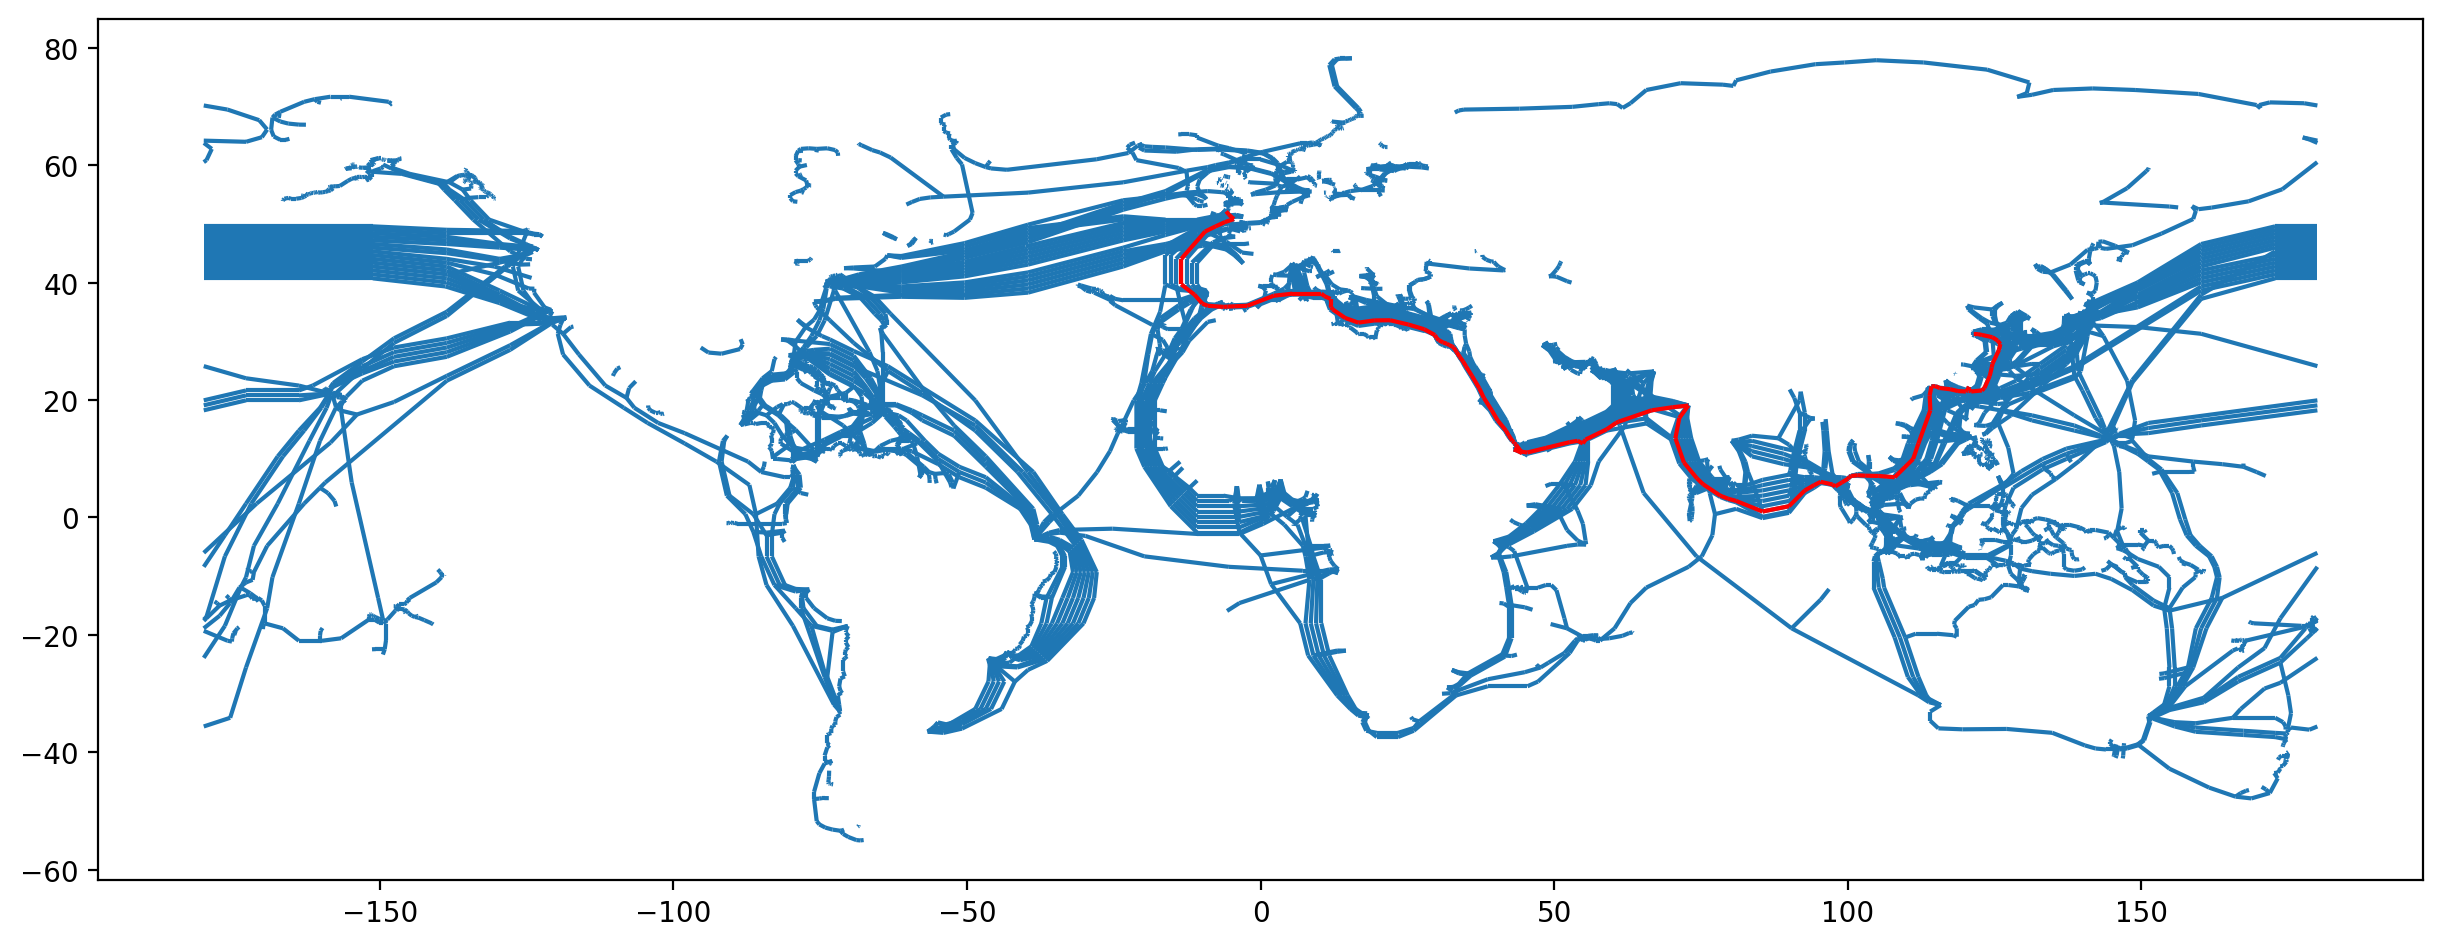

In [52]:
# shortest path in distance
path = nx.shortest_path(G,15272016, 4629267, weight = 'length_from_previous')


fig     = plt.figure(figsize=(15,10),dpi = 200)
ax      = plt.subplot(111)

path_road = getPath(path, gdf)
gdf.plot(ax=ax)
path_road.plot(ax = ax, color='red')

shortest_path_analysis_summary(path_road)

By passed 14 landing point
This route passed 22437.98093462744 km
The estimated latency for this route is 0.1121899046731372 s
With estimated cost of 564.6272222038509 million US $
Max capacity of 0.03Tb/s


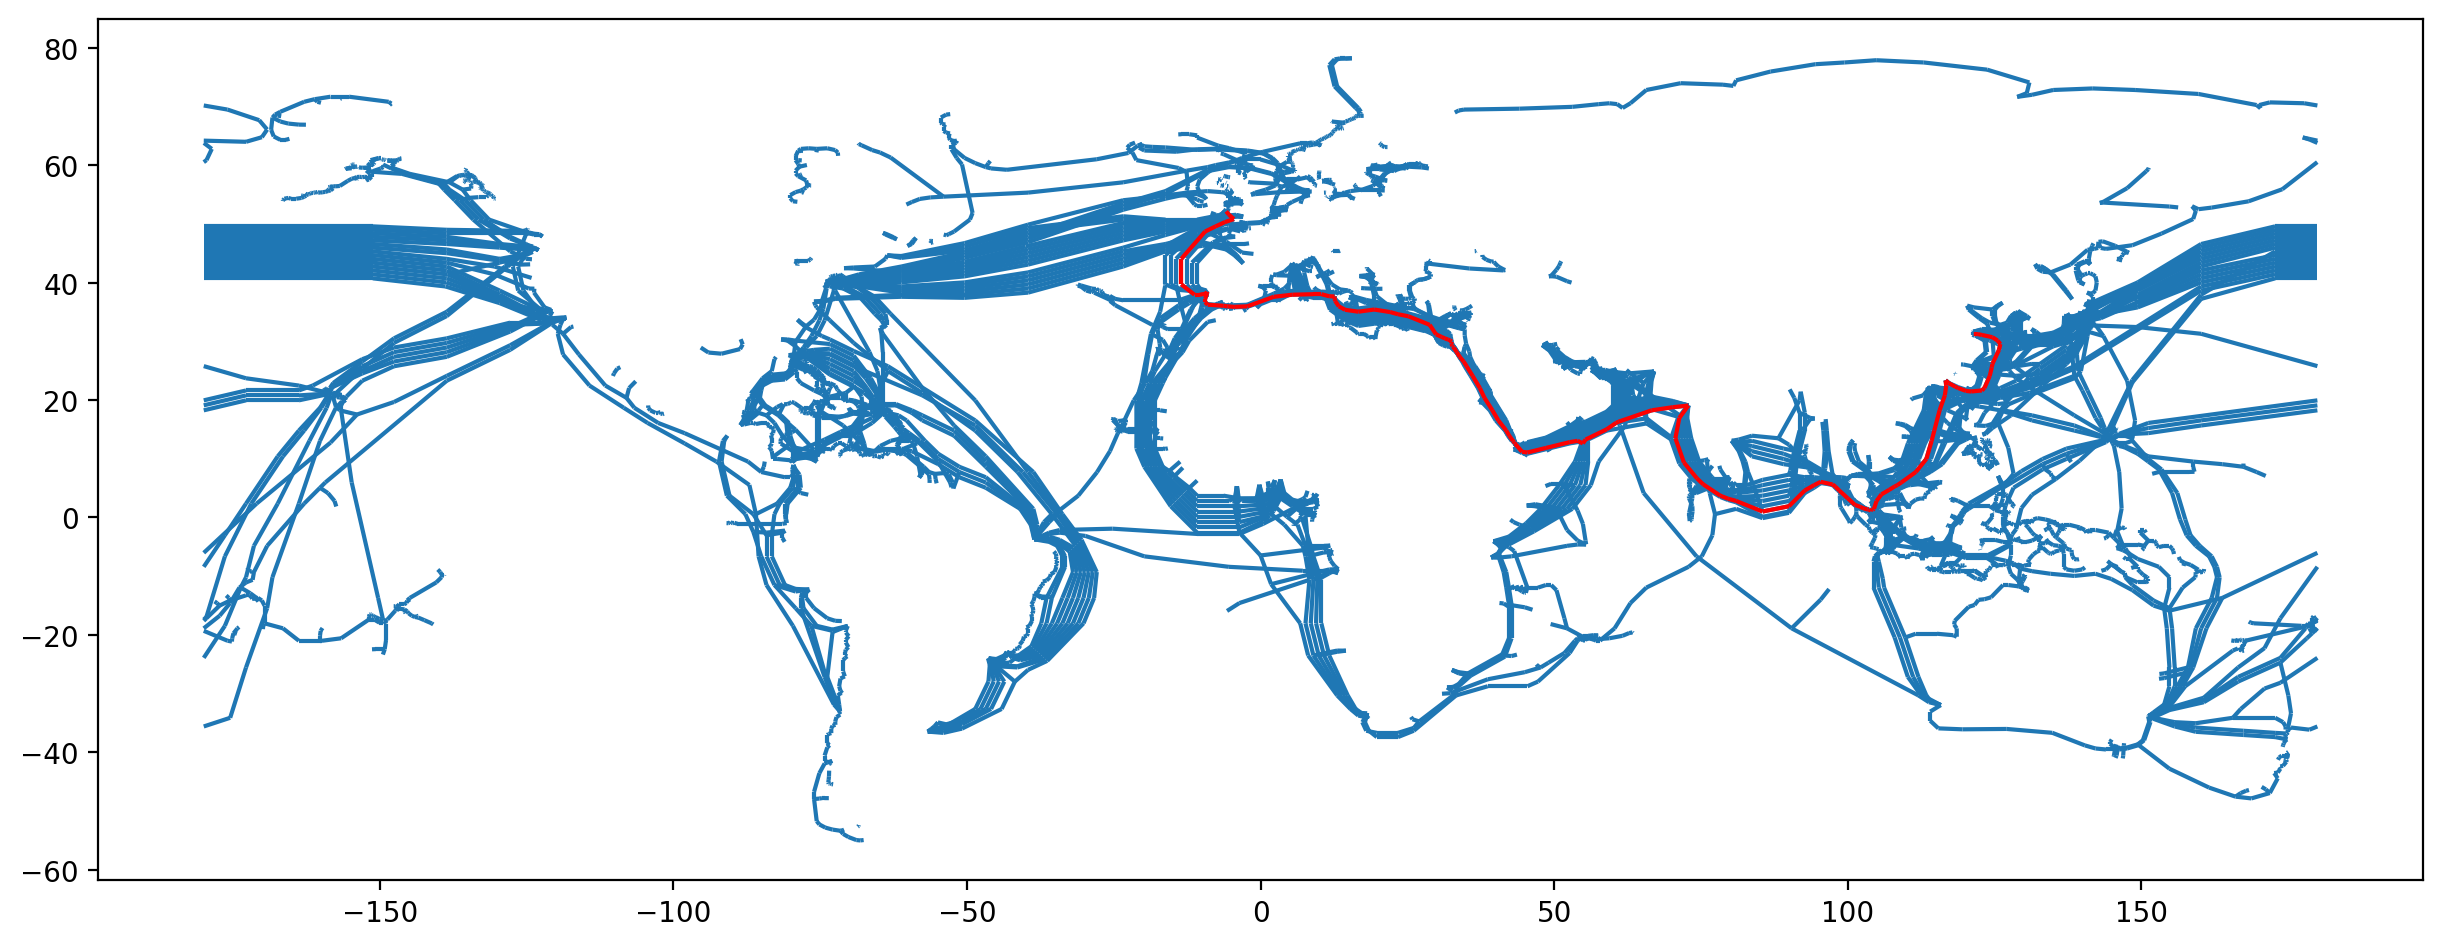

In [53]:
path = nx.shortest_path(G,15272016, 4629267, weight = 'segment_cost')


fig     = plt.figure(figsize=(15,10),dpi = 200)
ax      = plt.subplot(111)

path_road = getPath(path, gdf)
gdf.plot(ax=ax)
path_road.plot(ax = ax, color='red')

shortest_path_analysis_summary(path_road)

By passed 9 landing point
This route passed 36556.14586494072 km
The estimated latency for this route is 0.1827807293247036 s
With estimated cost of 961.4102100940016 million US $
Max capacity of 0.13985463762945624Tb/s


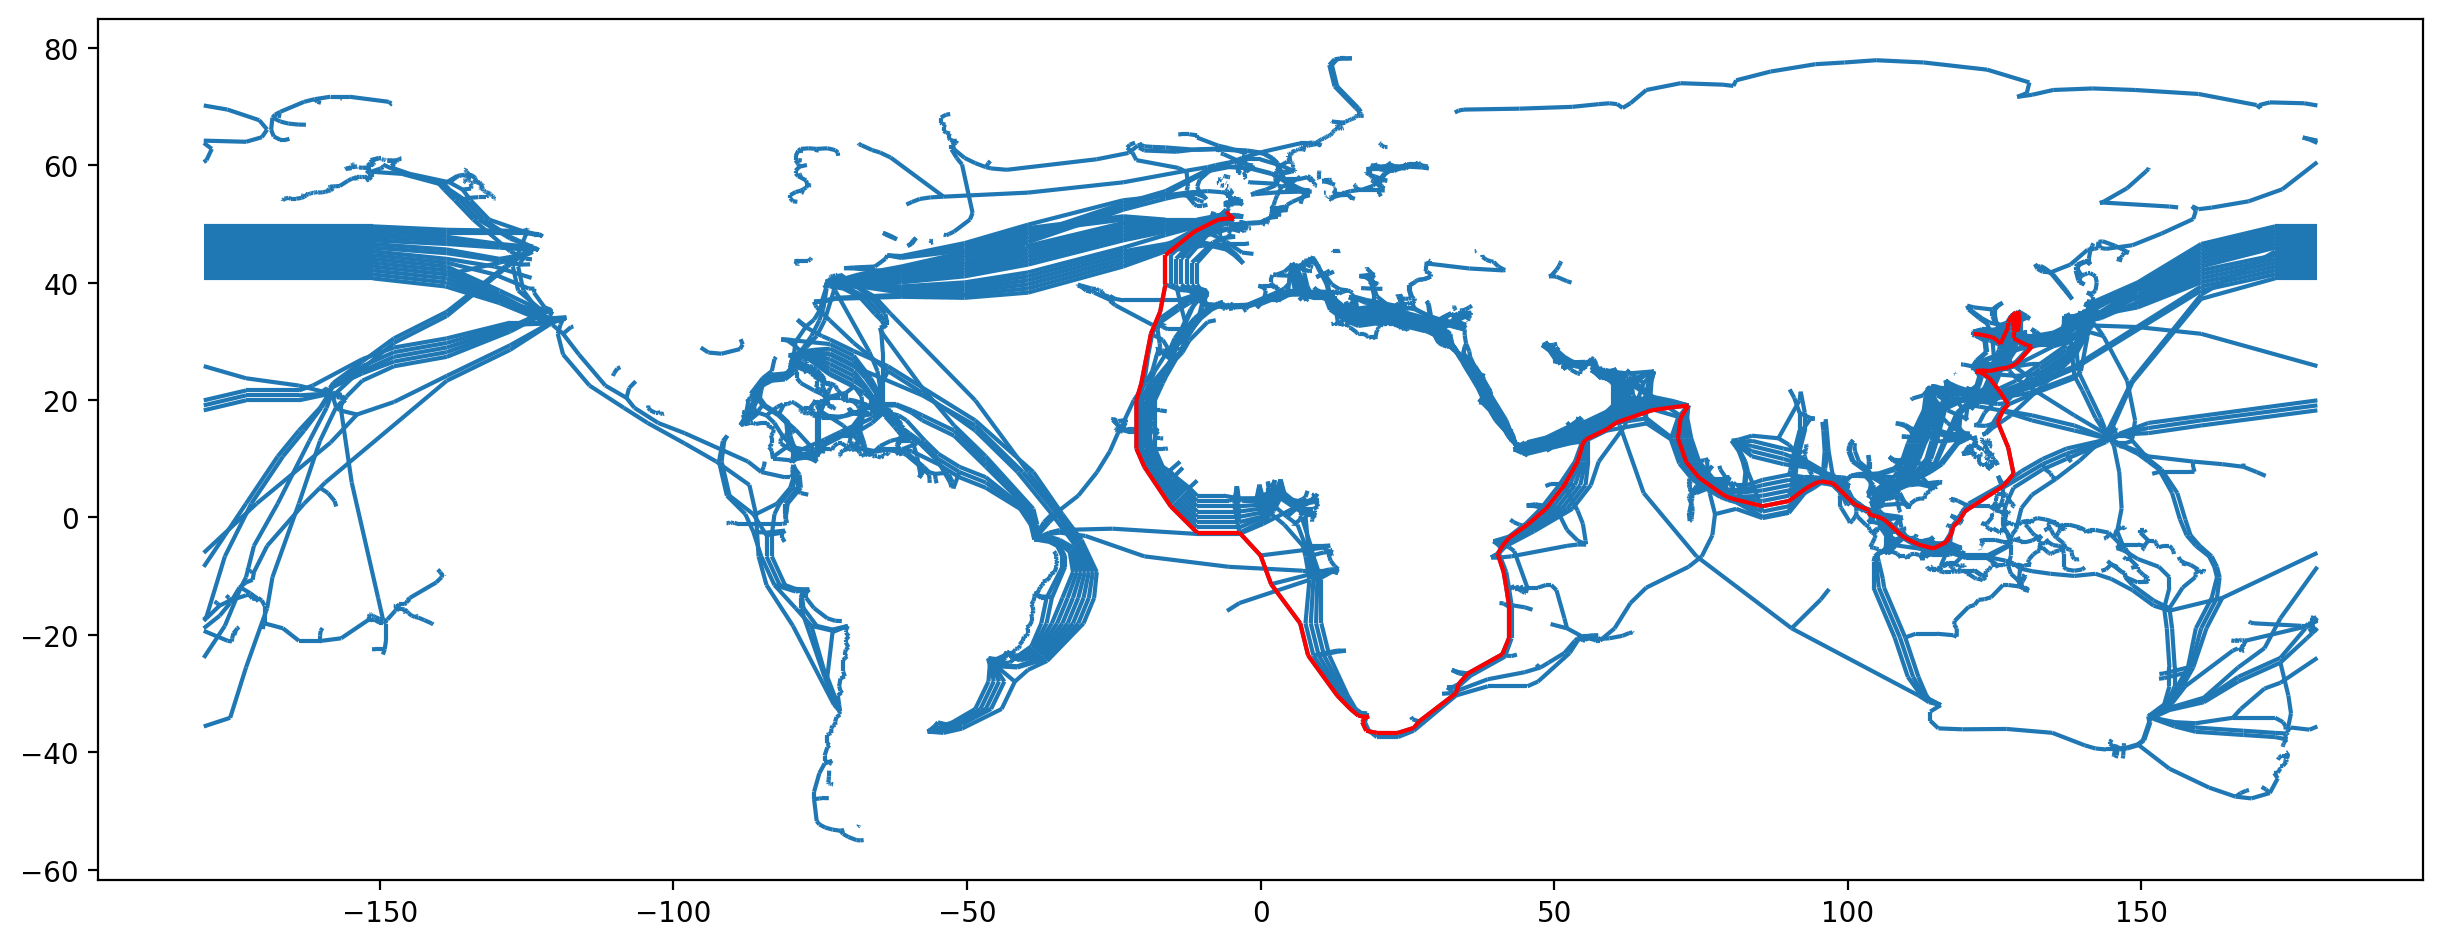

In [54]:
path = nx.shortest_path(G,15272016, 4629267, weight = 'inverse_capacity')


fig     = plt.figure(figsize=(15,10),dpi = 200)
ax      = plt.subplot(111)

path_road = getPath(path, gdf)
gdf.plot(ax=ax)
path_road.plot(ax = ax, color='red')

shortest_path_analysis_summary(path_road)

In [55]:
# efficiency: https://en.wikipedia.org/wiki/Efficiency_(network_science)
nx.algorithms.efficiency(G,15272016, 4629267)


0.00980392156862745

In [42]:
path_road.head()

,index,lon1,lat1,cable_id,cable_length,cable_capacity,cable_cost,lon2,lat2,fr_point,to_point,fr_id,to_id,distance_from_previous,total_distance,length_from_previous,segment_cost,inverse_capacity,line,geometry
7717,8801,30.825052,30.756490,flag-europe-asia-fea,28000.0,0.500000,720.00,29.893513,31.191465,POINT (30.82505 30.75649),POINT (29.89351 31.19147),6158154.0,6108498.0,1.028090,251.382733,114.512687,2.944612,2.00000,LINESTRING (30.825052399183477 30.756490442252...,"LINESTRING (30.82505 30.75649, 29.89351 31.19147)"
8006,9120,29.893513,31.191465,imewe,12091.0,3.323032,335.06,30.825052,31.190550,POINT (29.89351 31.19147),POINT (30.82505 31.19055),6108498.0,6201560.0,0.931540,115.756983,97.300805,2.696353,0.30093,LINESTRING (29.893513059094772 31.191465077638...,"LINESTRING (29.89351 31.19147, 30.82505 31.19055)"
8005,9119,30.825052,31.190550,imewe,12091.0,3.323032,335.06,31.387552,31.094220,POINT (30.82505 31.19055),POINT (31.38755 31.09422),6201560.0,6248177.0,0.570688,115.756983,59.609304,1.651864,0.30093,LINESTRING (30.825052399183477 31.190549751544...,"LINESTRING (30.82505 31.19055, 31.38755 31.09422)"
8004,9118,31.387552,31.094220,imewe,12091.0,3.323032,335.06,31.950052,30.877239,POINT (31.38755 31.09422),POINT (31.95005 30.87724),6248177.0,6282729.0,0.602899,115.756983,62.973703,1.745097,0.30093,LINESTRING (31.387552000703465 31.094220011720...,"LINESTRING (31.38755 31.09422, 31.95005 30.87724)"
8003,9117,31.950052,30.877239,imewe,12091.0,3.323032,335.06,32.287551,30.466025,POINT (31.95005 30.87724),POINT (32.28755 30.46602),6282729.0,6275357.0,0.531981,115.756983,55.566215,1.539824,0.30093,LINESTRING (31.950051602223482 30.877238883975...,"LINESTRING (31.95005 30.87724, 32.28755 30.46602)"


In [56]:
nx.shortest_path_length(G,15272016, 10373031, weight = 'length_from_previous')


5536.345022164888

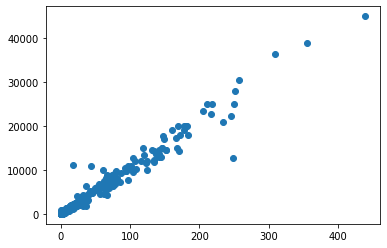

In [44]:
# path = nx.shortest_path(G,6158154, 4629267)


# fig     = plt.figure(figsize=(15,10),dpi = 200)
# ax      = plt.subplot(111)

# path_road = getPath(path, gdf)
# gdf.plot(ax=ax)
# path_road.plot(ax = ax, color='red')


with sqlite3.connect('../../Dataset/submarine_cable.sqlite') as con:
    c = con.cursor()
    temp = pd.read_sql("select sum(distance_from_previous) as cable_dis, cd.cable_id, cmlcc.merge_length as cable_length from cable_distance cd left join cable_merge_length_capacity_cost cmlcc on cd.cable_id = cmlcc.cable_id group by cd.cable_id",con=con)

plt.scatter(x= 'cable_dis', y='cable_length', data=temp)

<AxesSubplot:>

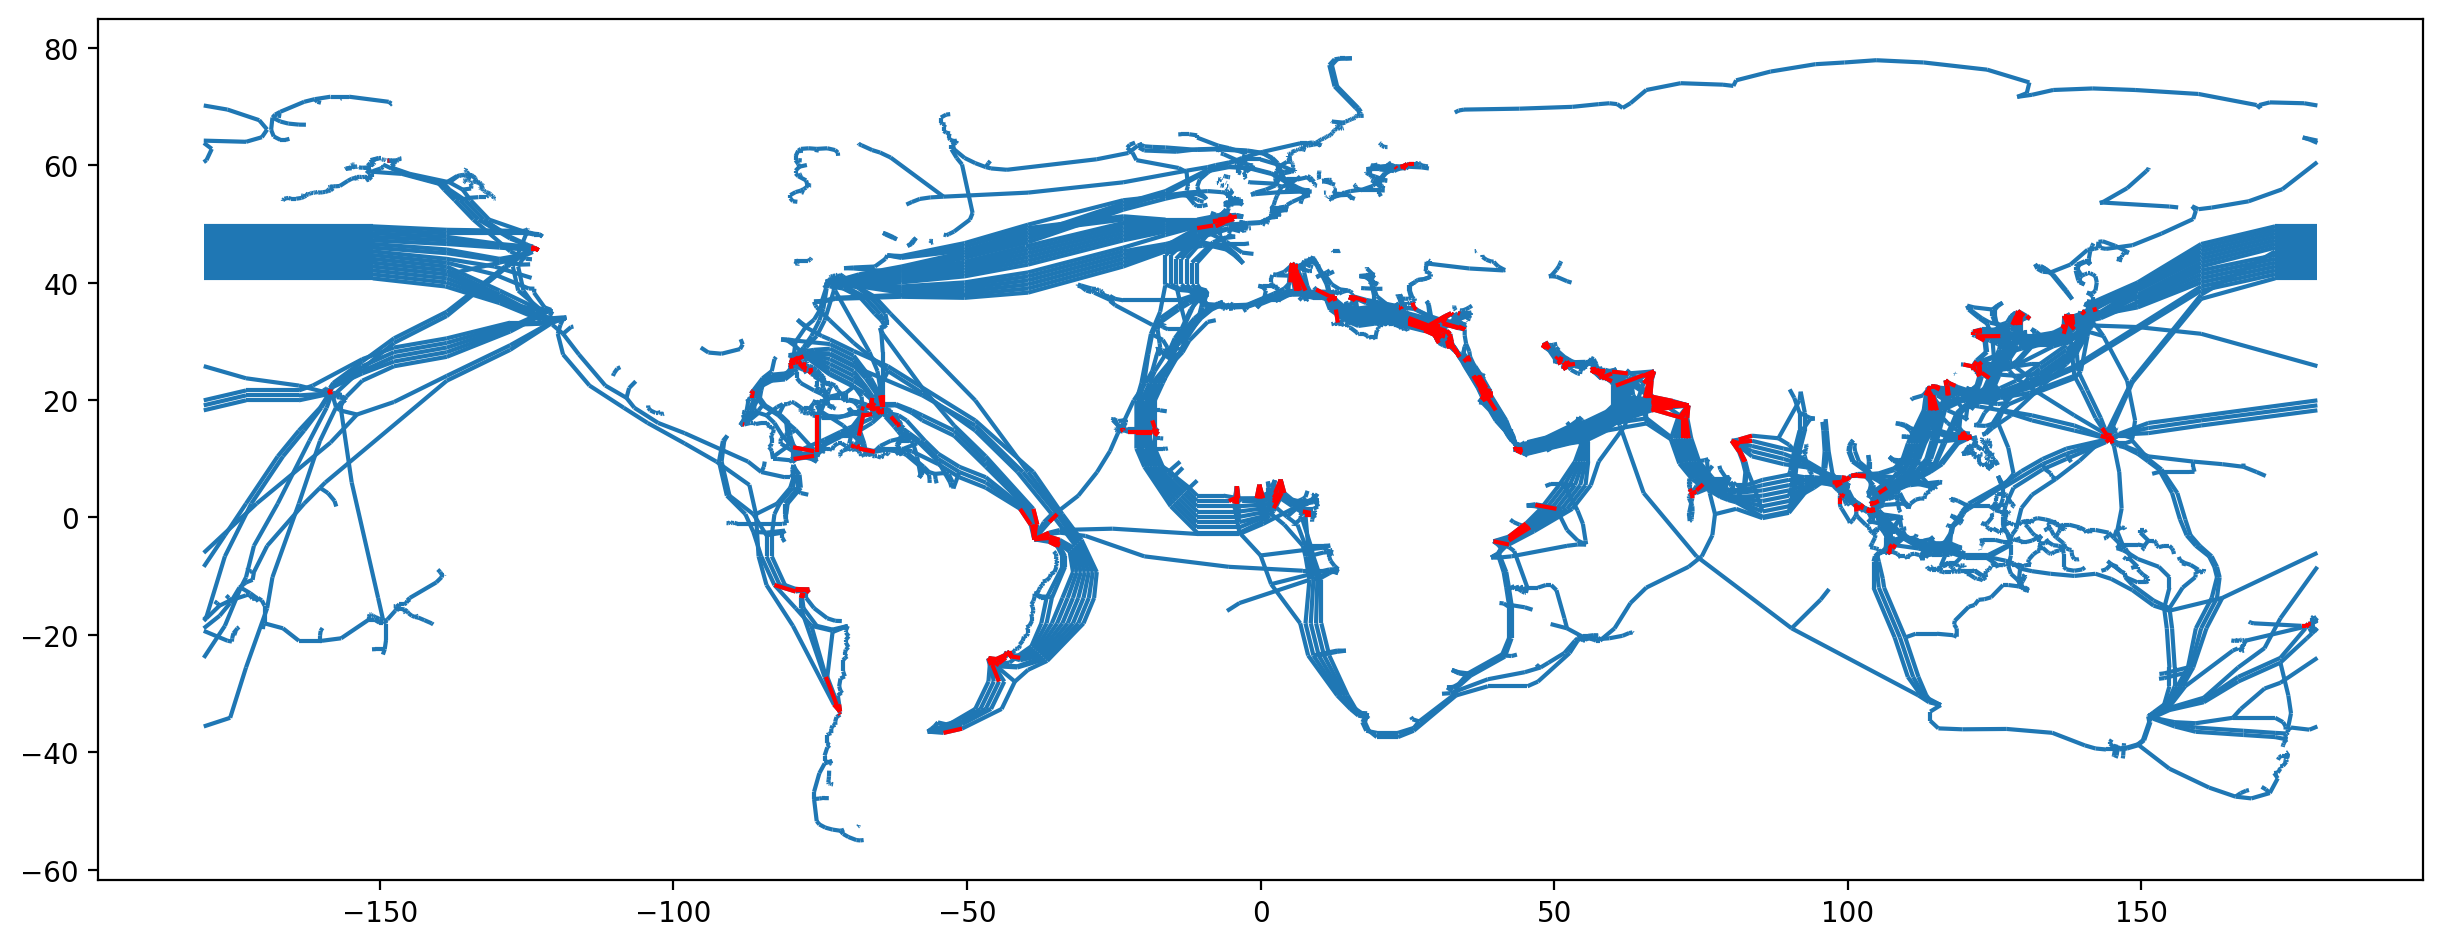

In [45]:
# https://networkx.org/documentation/networkx-1.9.1/reference/generated/networkx.algorithms.assortativity.average_degree_connectivity.html#networkx.algorithms.assortativity.average_degree_connectivity
temp = {}
for key, value in nx.average_neighbor_degree(G).items():
    if value >= 4:
        temp[key] = value
fig     = plt.figure(figsize=(15,10),dpi = 200)
ax      = plt.subplot(111)
gdf.plot(ax=ax)
gdf[gdf['fr_id'].isin(temp.keys()) ].plot(ax = ax, color='red')

In [46]:
# T = nx.minimum_spanning_tree(G, algorithm='kruskal')  # 返回包括最小生成树的图


# path_road = getPath(list (T), gdf)

# fig     = plt.figure(figsize=(15,10),dpi = 200)
# ax      = plt.subplot(111)
# gdf.plot(ax=ax)
# path_road.plot(ax = ax, color='red')

In [47]:
# T = nx.minimum_edge_cut(G)

In [48]:
with sqlite3.connect('../../Dataset/submarine_cable.sqlite') as con:
    c = con.cursor()
    landingPoint_connection = pd.read_sql("select count(*) as neighborCount, landingPoint_id, landingPoint_name, landingPoint_country, landingPoint_longitude, landingPoint_latitude from landing_points group by landingPoint_id having neighborCount >= 3",con=con)
    landingPoint = pd.read_sql("select * from landing_points",con=con)


landingPoint_connection_gdf = gpd.GeoDataFrame(landingPoint_connection, geometry=gpd.points_from_xy(x=landingPoint_connection['landingPoint_longitude'],y=landingPoint_connection['landingPoint_latitude']))

landingPoint_gdf = gpd.GeoDataFrame(landingPoint, geometry=gpd.points_from_xy(x=landingPoint['landingPoint_longitude'],y=landingPoint['landingPoint_latitude']))
# landingPoint_connection_gdf.plot()


# for x,y,price in zip(scatter_se.lon,scatter_se.lat,scatter_se['实用单价']):
#     hk_map.scatter(x,y,s=price/500,color='#FFEB3B',alpha=.5,ec='k',lw=.1)

In [49]:
# ax = gplt.polyplot(df=nyc_boroughs,
#                    projection=gcrs.AlbersEqualArea())
 
# # 叠加核密度图层
# ax = gplt.kdeplot(df=nyc_collision_factors,
#                   cmap='Reds',
#                   shade=True,
#                   shade_lowest=True,
#                   clip=nyc_boroughs,
#                   ax=ax)
 
# plt.savefig("图6.png", bbox_inches='tight', pad_inches=0, dpi=300)
landingPoint_connection_gdf

,neighborCount,landingPoint_id,landingPoint_name,landingPoint_country,landingPoint_longitude,landingPoint_latitude,geometry
0,6,abidjan-cte-divoire,"Abidjan, Côte d'Ivoire",Côte d'Ivoire,-4.026253,5.323494,POINT (-4.02625 5.32349)
1,6,abu-talat-egypt,"Abu Talat, Egypt",Egypt,29.702495,31.071849,POINT (29.70249 31.07185)
2,6,accra-ghana,"Accra, Ghana",Ghana,-0.200914,5.558502,POINT (-0.20091 5.55850)
3,3,al-faw-iraq,"Al Faw, Iraq",Iraq,48.531780,29.923671,POINT (48.53178 29.92367)
4,4,al-khobar-saudi-arabia,"Al Khobar, Saudi Arabia",Saudi Arabia,50.214262,26.286558,POINT (50.21426 26.28656)
...,...,...,...,...,...,...,...
190,6,willemstad-curaao,"Willemstad, Curaçao",Curaçao,-68.896605,12.095319,POINT (-68.89661 12.09532)
191,5,yanbu-saudi-arabia,"Yanbu, Saudi Arabia",Saudi Arabia,38.107016,24.070617,POINT (38.10702 24.07062)
192,7,yeroskipos-cyprus,"Yeroskipos, Cyprus",Cyprus,32.466688,34.766628,POINT (32.46669 34.76663)
193,8,zafarana-egypt,"Zafarana, Egypt",Egypt,32.649894,29.116662,POINT (32.64989 29.11666)


In [50]:
world_map = folium.Map()
heatdata = landingPoint[['landingPoint_latitude','landingPoint_longitude']].values.tolist()

HeatMap(heatdata,radius=15).add_to(world_map)



neighborCount=landingPoint_connection_gdf["neighborCount"]
lon=landingPoint_connection_gdf["landingPoint_longitude"]
lat=landingPoint_connection_gdf["landingPoint_latitude"]
num=neighborCount.shape[0]
for i in range(num):
    folium.CircleMarker(radius=float(neighborCount[i]),location=[lat[i],lon[i]],color="yellow",fill=True,fill_color="red",fill_opacity=0.7).add_to(world_map)


world_map